In [276]:
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor,ExtraTreesClassifier,RandomForestClassifier
from sklearn.preprocessing import StandardScaler,KBinsDiscretizer,LabelEncoder,MinMaxScaler
from sklearn.metrics import mean_squared_error,f1_score,confusion_matrix,log_loss
from sklearn.kernel_approximation import Nystroem
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA,NMF

from catboost import Pool, cv,CatBoostClassifier,CatBoostRegressor

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, concatenate,Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
import tensorflow_addons as tfa

from tqdm import tqdm

import lightgbm as lgb

import xgboost as xgb
from xgboost import XGBClassifier,XGBRegressor,DMatrix,plot_tree

from imblearn.over_sampling import RandomOverSampler,SMOTE, ADASYN

In [277]:
train_df = pd.read_csv('train_df_final.csv')
train_df = train_df.fillna(0)
train_df_org = pd.read_csv('train_df_final_blanced.csv')
train_df_org = train_df_org.fillna(0)
test_df = pd.read_csv('test_df_final.csv')
test_df = test_df.fillna(0)
submission_df = pd.read_csv('sample_submission.csv')

In [278]:
y = train_df['label'].values
y_org = train_df_org['label'].values

In [279]:
features = [
    'fare_per_distance',
    'fare_per_duration',
    'avg_speed',
    'meter_waiting_per_duration',
    'meter_waiting_fare_per_meter_waiting',
    'meter_waiting_fare_per_duration',
    'addtional_fare_per_fare',
    'addtional_fare_per_distance',
    'addtional_fare_per_duration',
    'fare-additional_fare_per_distance',
    'fare-additional_fare_per_duration',
    'fare-additional_fare-meter_waiting_fare_per_distance',
    'fare-additional_fare-meter_waiting_fare_per_duration',
    'meter_waiting_till_pickup_per_meter_waiting',
    'meter_waiting_after_pickup_per_duration',
    'meter_waiting_till_pickup_per_duration',
    'meter_waiting_till_pickup_per_distance',
    'meter_waiting_after_pickup_per_distance',
    'meter_waiting_till_pickup_per_fare',
    'meter_waiting_after_pickup_per_fare',
    'meter_waiting_till_pickup_per_meter_waiting_fare',
    'meter_waiting_after_pickup_per_meter_waiting_fare',    
]

cat_features = []

In [280]:
train = train_df[features]
test = test_df[features]
train_org = train_df_org[features]
y = train_df['label']
for each in cat_features:
    train[each] = train[each].values.astype(int)
    test[each] = test[each].values.astype(int)
    train_org[each] = train_org[each].values.astype(int)

In [281]:
catboost_params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
    'border_count':512
}

In [282]:
submission_pool = Pool(data=test_df[features], cat_features=cat_features)
org_pool = Pool(data=train_org[features], cat_features=cat_features)

In [283]:
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_class = np.zeros(train_df.shape[0])
test_class = np.zeros(test_df.shape[0])
skf = StratifiedKFold(n_splits=3)
validation_scores = []
org_scores = []
models = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**catboost_params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    train_preds[test_index] = model.predict_proba(test_pool)[:,1]
    train_class[test_index] = model.predict(test_pool)
    test_preds += model.predict_proba(submission_pool)[:,1]/3
    test_class += model.predict(submission_pool)
    validation_scores.append(f1_score(y_test,model.predict(test_pool),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(org_pool),average='micro'))
    models.append(model)
test_class = np.where(test_class > 2, 1, 0)

Learning rate set to 0.057693
0:	learn: 0.9637438	test: 0.9634802	best: 0.9634802 (0)	total: 23.4ms	remaining: 23.4s
10:	learn: 0.9706593	test: 0.9747052	best: 0.9749786 (9)	total: 190ms	remaining: 17.1s
20:	learn: 0.9737268	test: 0.9762337	best: 0.9763359 (19)	total: 317ms	remaining: 14.8s
30:	learn: 0.9750238	test: 0.9774249	best: 0.9774249 (30)	total: 453ms	remaining: 14.2s
40:	learn: 0.9757680	test: 0.9782713	best: 0.9783691 (39)	total: 578ms	remaining: 13.5s
50:	learn: 0.9766909	test: 0.9786337	best: 0.9787397 (46)	total: 701ms	remaining: 13s
60:	learn: 0.9773466	test: 0.9784297	best: 0.9787397 (46)	total: 848ms	remaining: 13.1s
70:	learn: 0.9778670	test: 0.9786214	best: 0.9787397 (46)	total: 982ms	remaining: 12.8s
80:	learn: 0.9782390	test: 0.9787152	best: 0.9789110 (77)	total: 1.12s	remaining: 12.7s
90:	learn: 0.9785625	test: 0.9787071	best: 0.9790049 (82)	total: 1.24s	remaining: 12.4s
100:	learn: 0.9789821	test: 0.9782171	best: 0.9790049 (82)	total: 1.4s	remaining: 12.5s
110:	l

In [284]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9566801773015498, 0.0053043619760975045, 0.9492484526967285)

In [285]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9557308157273616, 0.0029790683398620158, 0.9523343503540382)

In [286]:
best_model = models[np.argmax(validation_scores)]
best_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,fare_per_duration,12.739150
1,fare_per_distance,11.010050
2,fare-additional_fare_per_distance,10.463529
3,fare-additional_fare_per_duration,10.081825
4,fare-additional_fare-meter_waiting_fare_per_du...,8.632382
5,fare-additional_fare-meter_waiting_fare_per_di...,7.469266
6,meter_waiting_per_duration,6.240614
7,addtional_fare_per_fare,4.155153
8,meter_waiting_till_pickup_per_meter_waiting,3.225367
9,avg_speed,3.210664


In [287]:
y_hat = np.round(best_model.predict(train))
confusion_matrix(y,y_hat,normalize='pred')

array([[0.89635854, 0.03560644],
       [0.10364146, 0.96439356]])

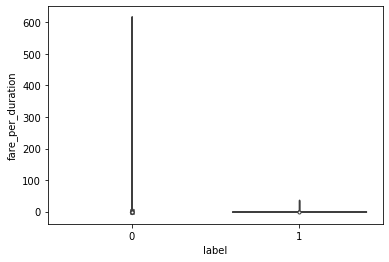

In [288]:
sns.violinplot(x='label',y='fare_per_duration',data=train_df)

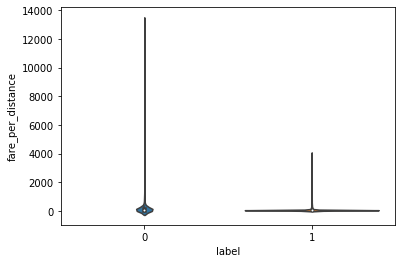

In [289]:
sns.violinplot(x='label',y='fare_per_distance',data=train_df)

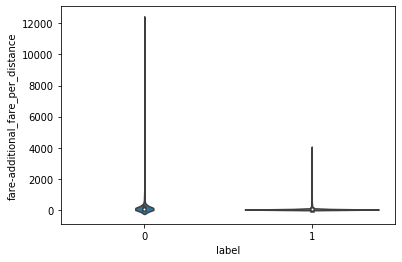

In [290]:
sns.violinplot(x='label',y='fare-additional_fare_per_distance',data=train_df)

# Col products

In [291]:
prod_cols = []
for i, col1 in enumerate(features):
    for col2 in features[i+1:]:
        name = f'{col1}@{col2}'
        train_df[name] = train_df[col1] * train_df[col2]
        test_df[name] = test_df[col1] * test_df[col2]
        train_df_org[name] = train_df_org[col1] * train_df_org[col2]
        prod_cols.append(name)

In [292]:
features = features + prod_cols

In [293]:
train = train_df[features]
test = test_df[features]
train_org = train_df_org[features]
y = train_df['label']

In [294]:
submission_pool = Pool(data=test_df[features], cat_features=cat_features)
org_pool = Pool(data=train_org[features], cat_features=cat_features)

In [295]:
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_class = np.zeros(train_df.shape[0])
test_class = np.zeros(test_df.shape[0])
skf = StratifiedKFold(n_splits=3)
validation_scores = []
org_scores = []
models = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**catboost_params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    train_preds[test_index] = model.predict_proba(test_pool)[:,1]
    train_class[test_index] = model.predict(test_pool)
    test_preds += model.predict_proba(submission_pool)[:,1]/3
    test_class += model.predict(submission_pool)
    validation_scores.append(f1_score(y_test,model.predict(test_pool),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(org_pool),average='micro'))
    models.append(model)
test_class = np.where(test_class > 2, 1, 0)

Learning rate set to 0.057693
0:	learn: 0.9600914	test: 0.9607037	best: 0.9607037 (0)	total: 53ms	remaining: 53s
10:	learn: 0.9692723	test: 0.9717868	best: 0.9717868 (10)	total: 667ms	remaining: 60s
20:	learn: 0.9731323	test: 0.9770905	best: 0.9772901 (19)	total: 1.29s	remaining: 1m
30:	learn: 0.9748892	test: 0.9780115	best: 0.9782068 (28)	total: 1.88s	remaining: 58.8s
40:	learn: 0.9760519	test: 0.9782837	best: 0.9782921 (35)	total: 2.47s	remaining: 57.8s
50:	learn: 0.9767486	test: 0.9786501	best: 0.9786582 (44)	total: 3.04s	remaining: 56.6s
60:	learn: 0.9776355	test: 0.9784586	best: 0.9788375 (54)	total: 3.62s	remaining: 55.7s
70:	learn: 0.9781455	test: 0.9780546	best: 0.9788375 (54)	total: 4.17s	remaining: 54.6s
80:	learn: 0.9787112	test: 0.9784379	best: 0.9788375 (54)	total: 4.77s	remaining: 54.1s
90:	learn: 0.9791796	test: 0.9783317	best: 0.9788375 (54)	total: 5.33s	remaining: 53.2s
100:	learn: 0.9797423	test: 0.9780336	best: 0.9788375 (54)	total: 5.94s	remaining: 52.9s
Stopped by 

In [296]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9570338361990803, 0.004893219677337751, 0.950132625994695)

In [297]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9561913534051004, 0.0036502634882538388, 0.9512405733694088)

In [298]:
best_model = models[np.argmax(validation_scores)]
best_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,fare_per_distance,7.650211
1,fare_per_distance@avg_speed,4.399818
2,fare_per_distance@fare-additional_fare_per_dis...,4.139117
3,fare_per_duration,3.686443
4,fare-additional_fare-meter_waiting_fare_per_di...,3.565296
...,...,...
248,meter_waiting_till_pickup_per_fare@meter_waiti...,0.000000
249,meter_waiting_till_pickup_per_fare@meter_waiti...,0.000000
250,meter_waiting_after_pickup_per_fare@meter_wait...,0.000000
251,meter_waiting_after_pickup_per_fare@meter_wait...,0.000000


In [299]:
y_hat = np.round(best_model.predict(train))
confusion_matrix(y,y_hat,normalize='pred')

array([[0.90222652, 0.03727877],
       [0.09777348, 0.96272123]])

In [300]:
submission_df['prediction'] = test_class
submission_df.to_csv('submission.csv',index=False)

submission_df['prediction'].sum() / submission_df.shape[0]

0.9465951492537313

## with 0 importance columns removed

In [25]:
model_1 = models[0]
df_1 = model_1.get_feature_importance(prettified=True)
set_1 = set(df_1[df_1['Importances'] == 0]['Feature Id'].values)

model_2 = models[1]
df_2 = model_2.get_feature_importance(prettified=True)
set_2 = set(df_2[df_2['Importances'] == 0]['Feature Id'].values)

model_3 = models[2]
df_3 = model_3.get_feature_importance(prettified=True)
set_3 = set(df_3[df_3['Importances'] == 0]['Feature Id'].values)

ignore = set_1.intersection(set_2,set_3)
ignore

{'addtional_fare_per_distance@meter_waiting_after_pickup_per_meter_waiting_fare',
 'fare-additional_fare_per_duration@meter_waiting_after_pickup_per_distance',
 'meter_waiting_fare_per_meter_waiting@meter_waiting_till_pickup_per_duration',
 'meter_waiting_till_pickup_per_fare@meter_waiting_after_pickup_per_meter_waiting_fare'}

In [26]:
features = [each for each in features if each not in ignore]

In [27]:
train = train_df[features]
test = test_df[features]
train_org = train_df_org[features]
y = train_df['label']

In [28]:
submission_pool = Pool(data=test_df[features], cat_features=cat_features)
org_pool = Pool(data=train_org[features], cat_features=cat_features)

In [29]:
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_class = np.zeros(train_df.shape[0])
test_class = np.zeros(test_df.shape[0])
skf = StratifiedKFold(n_splits=3)
validation_scores = []
org_scores = []
models = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**catboost_params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    train_preds[test_index] = model.predict_proba(test_pool)[:,1]
    train_class[test_index] = model.predict(test_pool)
    test_preds += model.predict_proba(submission_pool)[:,1]/3
    test_class += model.predict(submission_pool)
    validation_scores.append(f1_score(y_test,model.predict(test_pool),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(org_pool),average='micro'))
    models.append(model)
test_class = np.where(test_class > 2, 1, 0)

Learning rate set to 0.057693
0:	learn: 0.9631838	test: 0.9618552	best: 0.9618552 (0)	total: 57.9ms	remaining: 57.9s
10:	learn: 0.9698033	test: 0.9741199	best: 0.9741199 (10)	total: 693ms	remaining: 1m 2s
20:	learn: 0.9733200	test: 0.9770949	best: 0.9770949 (18)	total: 1.34s	remaining: 1m 2s
30:	learn: 0.9749476	test: 0.9780199	best: 0.9780199 (30)	total: 1.98s	remaining: 1m 1s
40:	learn: 0.9760168	test: 0.9781092	best: 0.9781134 (31)	total: 2.61s	remaining: 1m 1s
50:	learn: 0.9768463	test: 0.9783773	best: 0.9784792 (45)	total: 3.27s	remaining: 1m
60:	learn: 0.9779668	test: 0.9782671	best: 0.9784792 (45)	total: 3.92s	remaining: 1m
70:	learn: 0.9786623	test: 0.9785482	best: 0.9788334 (68)	total: 4.57s	remaining: 59.8s
80:	learn: 0.9794648	test: 0.9785441	best: 0.9788334 (68)	total: 5.21s	remaining: 59.1s
90:	learn: 0.9798851	test: 0.9788253	best: 0.9789232 (88)	total: 5.85s	remaining: 58.4s
100:	learn: 0.9803565	test: 0.9787152	best: 0.9790089 (96)	total: 6.48s	remaining: 57.7s
110:	lea

In [30]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9561496941660819, 0.0058200147295376144, 0.9480106100795755)

In [31]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9563448659643466, 0.0010576642127316496, 0.9553278452593402)

In [32]:
best_model = models[np.argmax(validation_scores)]
best_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,fare_per_distance@fare-additional_fare_per_dis...,5.872666
1,fare-additional_fare_per_distance@fare-additio...,4.533409
2,avg_speed@fare-additional_fare-meter_waiting_f...,3.567931
3,fare_per_duration,3.089657
4,fare-additional_fare_per_distance,3.051817
...,...,...
244,meter_waiting_till_pickup_per_distance@meter_w...,0.000000
245,meter_waiting_after_pickup_per_distance@meter_...,0.000000
246,meter_waiting_till_pickup_per_fare@meter_waiti...,0.000000
247,meter_waiting_till_pickup_per_fare@meter_waiti...,0.000000


In [33]:
y_hat = np.round(best_model.predict(train))
confusion_matrix(y,y_hat,normalize='pred')

array([[0.90644868, 0.03327871],
       [0.09355132, 0.96672129]])

# Log scale added

In [83]:
log_cols = []
for col in features:    
    name = f'log_{col}'
    train_df[name] = np.log(train_df[col] + 1)
    test_df[name] = np.log(test_df[col] + 1)
    train_df_org[name] = np.log(train_df_org[col] + 1)
    log_cols.append(name)

/home/heshan/anaconda3/envs/kaggle/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/heshan/anaconda3/envs/kaggle/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [84]:
features = features + log_cols

In [85]:
train = train_df[features]
test = test_df[features]
train_org = train_df_org[features]
y = train_df['label']

In [86]:
submission_pool = Pool(data=test_df[features], cat_features=cat_features)
org_pool = Pool(data=train_org[features], cat_features=cat_features)

In [87]:
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_class = np.zeros(train_df.shape[0])
test_class = np.zeros(test_df.shape[0])
skf = StratifiedKFold(n_splits=3)
validation_scores = []
org_scores = []
models = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**catboost_params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    train_preds[test_index] = model.predict_proba(test_pool)[:,1]
    train_class[test_index] = model.predict(test_pool)
    test_preds += model.predict_proba(submission_pool)[:,1]/3
    test_class += model.predict(submission_pool)
    validation_scores.append(f1_score(y_test,model.predict(test_pool),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(org_pool),average='micro'))
    models.append(model)
test_class = np.where(test_class > 2, 1, 0)

Learning rate set to 0.057693
0:	learn: 0.9652889	test: 0.9706190	best: 0.9706190 (0)	total: 123ms	remaining: 2m 2s
10:	learn: 0.9706050	test: 0.9742371	best: 0.9742371 (10)	total: 1.26s	remaining: 1m 53s
20:	learn: 0.9728548	test: 0.9766333	best: 0.9766333 (20)	total: 2.3s	remaining: 1m 47s
30:	learn: 0.9746522	test: 0.9780199	best: 0.9780199 (30)	total: 3.34s	remaining: 1m 44s
40:	learn: 0.9760496	test: 0.9784751	best: 0.9784792 (37)	total: 4.32s	remaining: 1m 41s
50:	learn: 0.9769797	test: 0.9788416	best: 0.9788456 (49)	total: 5.42s	remaining: 1m 40s
60:	learn: 0.9778628	test: 0.9783525	best: 0.9789353 (51)	total: 6.62s	remaining: 1m 41s
70:	learn: 0.9783285	test: 0.9786214	best: 0.9789353 (51)	total: 7.77s	remaining: 1m 41s
80:	learn: 0.9790290	test: 0.9788091	best: 0.9789353 (51)	total: 8.9s	remaining: 1m 41s
90:	learn: 0.9793572	test: 0.9789888	best: 0.9789888 (88)	total: 10.1s	remaining: 1m 40s
100:	learn: 0.9796876	test: 0.9788868	best: 0.9791767 (96)	total: 11.3s	remaining: 1m

In [88]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9567979732797077, 0.006224076130129417, 0.9480106100795755)

In [89]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9544259589737685, 0.0010128484808317674, 0.9531402912900812)

In [90]:
best_model = models[np.argmax(validation_scores)]
best_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,log_fare_per_distance@fare-additional_fare_per...,3.283644
1,fare_per_distance@avg_speed,3.250897
2,log_fare-additional_fare_per_distance,3.174924
3,fare_per_distance@fare-additional_fare-meter_w...,2.718134
4,log_fare_per_duration@fare-additional_fare_per...,2.684101
...,...,...
501,log_meter_waiting_after_pickup_per_distance@me...,0.000000
502,log_meter_waiting_after_pickup_per_distance@me...,0.000000
503,log_meter_waiting_till_pickup_per_fare@meter_w...,0.000000
504,log_meter_waiting_till_pickup_per_fare@meter_w...,0.000000


In [91]:
y_hat = np.round(best_model.predict(train))
confusion_matrix(y,y_hat,normalize='pred')

array([[0.89711191, 0.03354562],
       [0.10288809, 0.96645438]])

## With 0 importance columns removed

In [92]:
model_1 = models[0]
df_1 = model_1.get_feature_importance(prettified=True)
set_1 = set(df_1[df_1['Importances'] == 0]['Feature Id'].values)

model_2 = models[1]
df_2 = model_2.get_feature_importance(prettified=True)
set_2 = set(df_2[df_2['Importances'] == 0]['Feature Id'].values)

model_3 = models[2]
df_3 = model_3.get_feature_importance(prettified=True)
set_3 = set(df_3[df_3['Importances'] == 0]['Feature Id'].values)

ignore = set_1.intersection(set_2,set_3)
ignore

{'addtional_fare_per_distance@meter_waiting_after_pickup_per_duration',
 'addtional_fare_per_distance@meter_waiting_after_pickup_per_meter_waiting_fare',
 'addtional_fare_per_distance@meter_waiting_till_pickup_per_fare',
 'addtional_fare_per_duration@meter_waiting_after_pickup_per_distance',
 'addtional_fare_per_duration@meter_waiting_after_pickup_per_fare',
 'addtional_fare_per_duration@meter_waiting_till_pickup_per_distance',
 'addtional_fare_per_duration@meter_waiting_till_pickup_per_fare',
 'addtional_fare_per_fare@meter_waiting_after_pickup_per_duration',
 'addtional_fare_per_fare@meter_waiting_till_pickup_per_distance',
 'addtional_fare_per_fare@meter_waiting_till_pickup_per_duration',
 'addtional_fare_per_fare@meter_waiting_till_pickup_per_fare',
 'avg_speed@meter_waiting_till_pickup_per_fare',
 'avg_speed@meter_waiting_till_pickup_per_meter_waiting',
 'fare-additional_fare-meter_waiting_fare_per_distance@meter_waiting_till_pickup_per_meter_waiting',
 'fare-additional_fare-meter

In [93]:
features = [each for each in features if each not in ignore]

In [94]:
train = train_df[features]
test = test_df[features]
train_org = train_df_org[features]
y = train_df['label']

In [95]:
submission_pool = Pool(data=test_df[features], cat_features=cat_features)
org_pool = Pool(data=train_org[features], cat_features=cat_features)

In [96]:
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_class = np.zeros(train_df.shape[0])
test_class = np.zeros(test_df.shape[0])
skf = StratifiedKFold(n_splits=3)
validation_scores = []
org_scores = []
models = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**catboost_params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    train_preds[test_index] = model.predict_proba(test_pool)[:,1]
    train_class[test_index] = model.predict(test_pool)
    test_preds += model.predict_proba(submission_pool)[:,1]/3
    test_class += model.predict(submission_pool)
    validation_scores.append(f1_score(y_test,model.predict(test_pool),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(org_pool),average='micro'))
    models.append(model)
test_class = np.where(test_class > 2, 1, 0)

Learning rate set to 0.057693
0:	learn: 0.9664955	test: 0.9666698	best: 0.9666698 (0)	total: 81.9ms	remaining: 1m 21s
10:	learn: 0.9711758	test: 0.9749548	best: 0.9749548 (10)	total: 981ms	remaining: 1m 28s
20:	learn: 0.9734513	test: 0.9768952	best: 0.9772727 (19)	total: 2.02s	remaining: 1m 34s
30:	learn: 0.9749500	test: 0.9783045	best: 0.9784063 (29)	total: 3.08s	remaining: 1m 36s
40:	learn: 0.9763359	test: 0.9785687	best: 0.9786746 (37)	total: 4.07s	remaining: 1m 35s
50:	learn: 0.9769731	test: 0.9785482	best: 0.9787438 (48)	total: 5.04s	remaining: 1m 33s
60:	learn: 0.9776226	test: 0.9784462	best: 0.9787438 (48)	total: 6.06s	remaining: 1m 33s
70:	learn: 0.9787886	test: 0.9783317	best: 0.9787438 (48)	total: 6.94s	remaining: 1m 30s
80:	learn: 0.9791697	test: 0.9780420	best: 0.9787438 (48)	total: 7.96s	remaining: 1m 30s
90:	learn: 0.9795918	test: 0.9781358	best: 0.9787438 (48)	total: 9.01s	remaining: 1m 29s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9787437763
be

In [97]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9565622354202074, 0.0060473430438493835, 0.9480106100795755)

In [98]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9543875808339569, 0.0030898573803650564, 0.9503194980139312)

In [99]:
best_model = models[np.argmax(validation_scores)]
best_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,fare_per_distance,4.235246
1,fare_per_duration,2.918840
2,fare_per_distance@fare-additional_fare_per_dis...,2.561977
3,log_fare_per_distance@avg_speed,2.289241
4,log_fare-additional_fare-meter_waiting_fare_pe...,1.756262
...,...,...
399,log_meter_waiting_till_pickup_per_distance@met...,0.000000
400,log_meter_waiting_after_pickup_per_distance@me...,0.000000
401,log_meter_waiting_after_pickup_per_distance@me...,0.000000
402,log_meter_waiting_till_pickup_per_fare@meter_w...,0.000000


In [100]:
y_hat = np.round(best_model.predict(train))
confusion_matrix(y,y_hat,normalize='pred')

array([[0.91238938, 0.03125592],
       [0.08761062, 0.96874408]])

# PCA

In [301]:
n_components=40

In [302]:
X_train = train_df[features].values
X_train_org = train_df_org[features].values
X_test = test_df[features].values

In [303]:
pca = PCA(n_components=n_components)
X_train_transformed = pca.fit_transform(X_train)
X_test_transformed = pca.transform(X_test)
X_train_org_transformed = pca.transform(X_train_org)

In [304]:
pca_train = pd.DataFrame()
pca_train['label'] = train_df['label']

pca_train_org = pd.DataFrame()
pca_train_org['label'] = y_org

pca_test = pd.DataFrame()
for i in range(n_components):
    name = f'col_{i}'
    pca_train[name] = X_train_transformed[:,i]
    pca_test[name] = X_test_transformed[:,i]
    pca_train_org[name] = X_train_org_transformed[:,i]
    

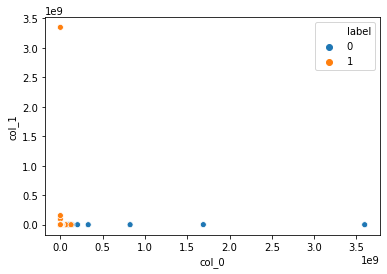

In [305]:
sns.scatterplot(x='col_0',y='col_1',data=pca_train,hue='label')

In [306]:
pca_cols = list(pca_test.columns)
for each in pca_cols:
    train_df[each] = pca_train[each]
    test_df[each] = pca_test[each]
    train_df_org[each] = pca_train_org[each]

In [307]:
features = features + pca_cols

In [308]:
train = train_df[features]
test = test_df[features]
train_org = train_df_org[features]
y = train_df['label']

In [309]:
submission_pool = Pool(data=test_df[features], cat_features=cat_features)
org_pool = Pool(data=train_org[features], cat_features=cat_features)

In [310]:
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_class = np.zeros(train_df.shape[0])
test_class = np.zeros(test_df.shape[0])
skf = StratifiedKFold(n_splits=3)
validation_scores = []
org_scores = []
models = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**catboost_params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    train_preds[test_index] = model.predict_proba(test_pool)[:,1]
    train_class[test_index] = model.predict(test_pool)
    test_preds += model.predict_proba(submission_pool)[:,1]/3
    test_class += model.predict(submission_pool)
    validation_scores.append(f1_score(y_test,model.predict(test_pool),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(org_pool),average='micro'))
    models.append(model)
test_class = np.where(test_class > 2, 1, 0)

Learning rate set to 0.057693
0:	learn: 0.9662024	test: 0.9697434	best: 0.9697434 (0)	total: 65.5ms	remaining: 1m 5s
10:	learn: 0.9713228	test: 0.9746618	best: 0.9749261 (1)	total: 776ms	remaining: 1m 9s
20:	learn: 0.9730784	test: 0.9767176	best: 0.9769040 (18)	total: 1.51s	remaining: 1m 10s
30:	learn: 0.9753098	test: 0.9784833	best: 0.9784833 (30)	total: 2.25s	remaining: 1m 10s
40:	learn: 0.9764891	test: 0.9786623	best: 0.9786664 (32)	total: 3s	remaining: 1m 10s
50:	learn: 0.9774637	test: 0.9786501	best: 0.9788497 (41)	total: 3.71s	remaining: 1m 9s
60:	learn: 0.9782474	test: 0.9781609	best: 0.9788497 (41)	total: 4.45s	remaining: 1m 8s
70:	learn: 0.9789922	test: 0.9782379	best: 0.9788497 (41)	total: 5.2s	remaining: 1m 7s
80:	learn: 0.9794609	test: 0.9778502	best: 0.9788497 (41)	total: 5.92s	remaining: 1m 7s
90:	learn: 0.9801686	test: 0.9782254	best: 0.9788497 (41)	total: 6.66s	remaining: 1m 6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9788496507
bestIteration 

In [311]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9563265600906434, 0.00519109726489741, 0.9490716180371352)

In [312]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9525070519831904, 0.002609007931293489, 0.9493408554487364)

In [313]:
best_model = models[np.argmax(validation_scores)]
best_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,fare_per_distance@fare-additional_fare_per_dur...,6.175151
1,fare-additional_fare-meter_waiting_fare_per_di...,4.581372
2,fare_per_distance@fare-additional_fare-meter_w...,4.398438
3,avg_speed@fare-additional_fare_per_distance,4.236665
4,fare-additional_fare_per_distance@fare-additio...,4.058057
...,...,...
288,col_33,0.000000
289,col_36,0.000000
290,col_37,0.000000
291,col_38,0.000000


In [314]:
y_hat = np.round(best_model.predict(train))
confusion_matrix(y,y_hat,normalize='pred')

array([[0.90854271, 0.03894315],
       [0.09145729, 0.96105685]])

In [315]:
best_model.get_feature_importance(prettified=True)[:30]

,Feature Id,Importances
0,fare_per_distance@fare-additional_fare_per_dur...,6.175151
1,fare-additional_fare-meter_waiting_fare_per_di...,4.581372
2,fare_per_distance@fare-additional_fare-meter_w...,4.398438
3,avg_speed@fare-additional_fare_per_distance,4.236665
4,fare-additional_fare_per_distance@fare-additio...,4.058057
5,fare_per_duration@fare-additional_fare_per_dis...,3.492866
6,fare_per_distance@avg_speed,3.301717
7,fare_per_distance,3.229522
8,fare_per_duration,2.821275
9,fare-additional_fare_per_duration@fare-additio...,2.767825


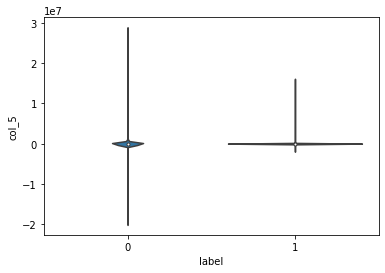

In [316]:
sns.violinplot(x='label',y='col_5',data=train_df)

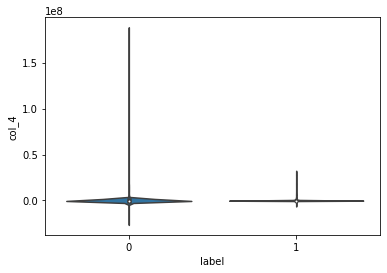

In [317]:
sns.violinplot(x='label',y='col_4',data=train_df)